#**Tata IPL - 2025 Data _Analysis_**


In [0]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
spark = SparkSession.builder.appName("IPL 2025 Analysis").getOrCreate()

In [0]:
deliveries_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://ipl2025-project/deliveries.csv")

### **Loading 4 Datasets - Deliveries, Matches, OrangeCap and PurpleCap**

In [0]:
matches_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://ipl2025-project/matches.csv")


In [0]:
orangeCap_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://ipl2025-project/orange_cap.csv")

In [0]:
purpleCap_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("s3://ipl2025-project/purple_cap.csv")

### **Total No. of Matches Played VS Toss with Match WIN**

In [0]:
team1_df = matches_df.select(col("team1").alias("team"))
team2_df = matches_df.select(col("team2").alias("team"))

combined_teams_df = team1_df.union(team2_df)

total_matches_df = combined_teams_df.groupBy("team") \
    .agg(count("*").alias("total_matches"))

toss_and_match_df = matches_df.filter(
    (col("toss_winner").isNotNull()) &
    (col("match_winner").isNotNull()) &
    (col("toss_winner") == col("match_winner")))

toss_match_wins_df = toss_and_match_df.groupBy("match_winner") \
    .agg(count("*").alias("toss_and_match_wins")) \
    .withColumnRenamed("match_winner", "team")

toss_and_match_win_df = total_matches_df.join(toss_match_wins_df, on="team", how="left") \
    .fillna(0, subset=["toss_and_match_wins"]) \
    .orderBy(col("toss_and_match_wins").desc())

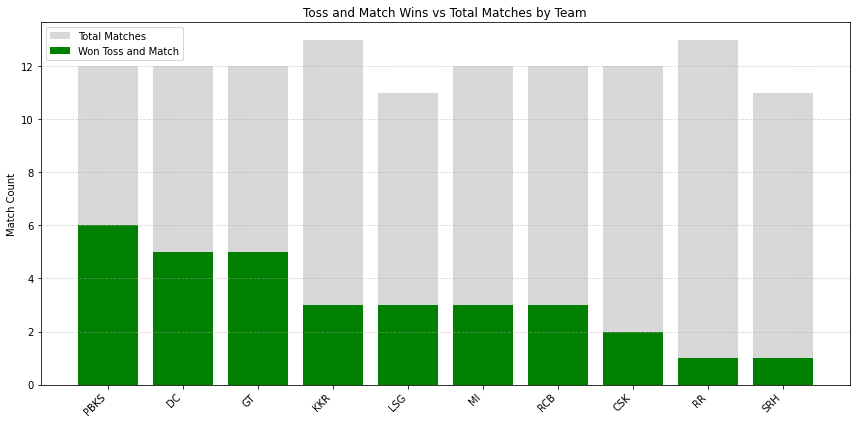

In [0]:
# 6. Convert to Pandas for plotting
pandas_df = toss_and_match_win_df.toPandas()
pandas_df['toss_and_match_wins'] = pandas_df['toss_and_match_wins'].astype(int)
pandas_df['total_matches'] = pandas_df['total_matches'].astype(int)

# 7. Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['team'], pandas_df['total_matches'], alpha=0.3, label='Total Matches', color='grey')
plt.bar(pandas_df['team'], pandas_df['toss_and_match_wins'], label='Won Toss and Match', color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Match Count")
plt.title("Toss and Match Wins vs Total Matches by Team")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

### **Most Extra runs given by each team**

In [0]:
extras_df = deliveries_df.groupby("bowling_team") \
    .agg(sum("extras").alias("total_extras")) \
    .orderBy(col("total_extras").desc())

In [0]:
pandas_df = extras_df.toPandas()

import plotly.express as px
import plotly.graph_objects as go

# Create interactive bar chart
fig = px.bar(pandas_df.sort_values('total_extras', ascending=True), 
             x='total_extras', 
             y='bowling_team',
             orientation='h',
             title='Total Extras by Bowling Team',
             labels={'total_extras': 'Total Extras', 'bowling_team': 'Bowling Team'},
             color='total_extras',
             color_continuous_scale='Blues')

# Customize layout
fig.update_layout(
    height=600,
    showlegend=False,
    title_font_size=16,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14
)

# Add value annotations
fig.update_traces(texttemplate='%{x}', textposition='outside')

fig.show()

### **Top 5 Most run scorer in 2025 with Orange Cap Holder**

In [0]:


orange_cap_df = deliveries_df.groupBy("striker") \
  .agg(sum("runs_of_bat").alias("Runs")) \
    .orderBy(col("Runs").desc())

### **Orange Cap holder - Sai Sudharsan**

In [0]:
orange_cap_df.show(5)

+----------------+----+
|         striker|Runs|
+----------------+----+
|   Sai Sudharsan| 617|
|    Shubman Gill| 601|
|         Jaiswal| 523|
|Suryakumar Yadav| 510|
|           Kohli| 505|
+----------------+----+
only showing top 5 rows



### **Top Performing Batsman and Bowler per Team**

In [0]:

team_runs = deliveries_df.groupBy("batting_team", "striker") \
    .agg(sum("runs_of_bat").alias("total_runs"))

window = Window.partitionBy("batting_team").orderBy(col("total_runs").desc())

ranked = team_runs.withColumn("rn", row_number().over(window))

batsman_df = ranked.filter(col("rn") == 1) \
    .select(
        col("batting_team").alias("team"),
        col("striker").alias("top_batsman"),
        "total_runs") \
    .orderBy(col("total_runs").desc())

In [0]:
valid_wicket = deliveries_df \
    .withColumn("is_valid_wicket", 
            when (
                (col("wicket_type").isNotNull()) &
                (~col("wicket_type").isin("'run out', 'retired hurt', 'obstructing the field'")),
                1).otherwise(0)
    )

total_wicket = valid_wicket.groupBy("bowling_team", "bowler") \
    .agg(sum("is_valid_wicket").alias("total_wickets"))

window = Window.partitionBy("bowling_team").orderBy(col("total_wickets").desc())

ranked = total_wicket.withColumn("rn", row_number().over(window))

bowler_df = ranked.filter(col("rn") == 1) \
    .select(col("bowling_team").alias("team"), 
            col("bowler").alias("top_bowler"),
            "total_wickets") \
    .orderBy(col("total_wickets").desc())

In [0]:
batsmen_df = batsman_df.toPandas()
bowlers_df = bowler_df.toPandas()

from plotly.subplots import make_subplots

fig_combined = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Top Run Scorer by Team', 'Top Wicket Taker by Team'),
    horizontal_spacing=0.1
)

# Add run scorers
fig_combined.add_trace(
    go.Bar(
        y=batsmen_df['team'],
        x=batsmen_df['total_runs'],
        orientation='h',
        name='Runs',
        text=[f"{player}<br>{runs}" for player, runs in zip(batsmen_df['top_batsman'], batsmen_df['total_runs'])],
        textposition='outside',
        marker_color='lightcoral',
        hovertemplate='<b>%{y}</b><br>Player: %{text}<br>Runs: %{x}<extra></extra>'
    ),
    row=1, col=1
)

# Add wicket takers
fig_combined.add_trace(
    go.Bar(
        y=bowlers_df['team'],
        x=bowlers_df['total_wickets'],
        orientation='h',
        name='Wickets',
        text=[f"{player}<br>{wickets}" for player, wickets in zip(bowlers_df['top_bowler'], bowlers_df['total_wickets'])],
        textposition='outside',
        marker_color='lightblue',
        hovertemplate='<b>%{y}</b><br>Player: %{text}<br>Wickets: %{x}<extra></extra>'
    ),
    row=1, col=2
)

fig_combined.update_layout(
    height=600,
    title_text="Top Performers by Team",
    title_font_size=16,
    showlegend=False
)

fig_combined.update_xaxes(title_text="Total Runs", row=1, col=1)
fig_combined.update_xaxes(title_text="Total Wickets", row=1, col=2)
fig_combined.update_yaxes(title_text="Team", row=1, col=1)
fig_combined.update_yaxes(title_text="Team", row=1, col=2)

fig_combined.show()
